## **Genre Classification**

I've chosen to build a genre classifier for my final project! This project has the most readily available data (scraping Spotify using the `spotipy` library) and should be doable within my timeline

## **Problem Statement**

Using features derived from an audio source itself, can a classification model predict the genre of a 30-second audio clip with high enough accuracy to organize new songs into their respective genres?

Classifying genre is important for music distribution and streaming platforms, it also helps listeners find new bands they might like, and it, in turn, helps musicians connect with new audiences.

My goal is to be able to predict genre using **features derived from the audio signal** to classify genre. This could be helpful in building playlists that translate across genre, but maintain a similar sound world for a consistent listening experience.

## **Methods and models**

### Data Collection

Scraping 30-second song samples using `spotipy` - I will start with 5 general genres and dig down into the subgenres of each:

* Classical
 * Baroque
 * Contemporary
* Country
 * Bluegrass
 * Folk
* Rock
 * Classic Rock
 * Metal
* Electronic
 * Trance
 * House
* R & B
 * Soul
 * Funk

### Methods for cleaning and preprocessing data

Using existing techniques gleaned from the [Music information retrieval](https://musicinformationretrieval.com/index.html) community, I'll **normalize** 30-second song samples to an equal volume, then use various methods for extracting features from the music itself. I still have more research to do to solidify exactly what methods I'll be using, but some include:
* `Fast Fourier Transform (fft)` - converting a time-window of an audio source into a snapshot of the frequency spectrum
* `Mel Frequency Cepstral Coefficients (mfcc)` - Still not 100% sure what this does, but it creates bins within a frequency range (from 
* `Noise reduction` - I shouldn't have too much noise since these are songs that have been posted to Spotify
* `Frequency Band Selection/isolation` - Used to try to isolate instruments/sounds
* `Spectral analysis/isolation` - detailed approach for instrument/sound extraction

### Models

Audio signal can be converted into images using the above preprocessing steps. It's increasingly popular to use neural networks to classify audio. Neural nets have proven very effective at classifying bird calls and instruments, so I will use one to classify genre, as well.

My computer is set up to be able to run neural networks, but I still have research to do before I create my first model.

There may already be existing models for genre classification, and if I find those, I'll likely include those in my project to increase the strength of my model.

## **Importing data**

This is my first time using spotipy, so I'm just grabbing random songs to perform some basic EDA, these will not be the genres I eventually use for my model.

In [1]:
import os
import spotipy
from auth import generate_token
import urllib
import librosa
import numpy as np
from funcs import *
import pandas as pd
import regex
from string import punctuation
import time
from python_speech_features import mfcc, logfbank

In [2]:
def write_tracks(text_file, tracks):
    with open(text_file, 'a') as file_out:
        while True:
            for item in tracks['items']:
                if 'track' in item:
                    track = item['track']
                else:
                    track = item
                try:
                    track_url = track['external_urls']['spotify']
                    file_out.write(track_url + '\n')
                except KeyError:
                    print(u'Skipping track {0} by {1} (local only?)'.format(
                            track['name'], track['artists'][0]['name']))
            # 1 page = 50 results
            # check if there are more pages
            if tracks['next']:
                tracks = spotify.next(tracks)
            else:
                break


def write_playlist(username, playlist_id):
    results = spotify.user_playlist(username, playlist_id,
                                    fields='tracks,next,name')
    text_file = u'{0}.txt'.format(results['name'], ok='-_()[]{}')
    print(u'Writing {0} tracks to {1}'.format(
            results['tracks']['total'], text_file))
    tracks = results['tracks']
    write_tracks(text_file, tracks)


token = generate_token()
spotify = spotipy.Spotify(auth=token)

# example playlist
write_playlist('22dpf7epvioqx3sieesnk7uvq', '2zDq0w1An95BO6MdOPg7sR')

Writing 94 tracks to Playlist ➤ Metal 🎸.txt


In [3]:
def playlist_to_genres(user_id, playlist_id):
    '''
    Function to iterate through a playlist, pull 30-second samples of songs,
    and separate them out into their genres. Some songs have multiple
    genres, so they will appear in multiple folders.
    '''
    spotify = spotipy.Spotify(auth=token) # Authorization token
    results = spotify.user_playlist(user=user_id, 
                                    playlist_id=playlist_id)
    
    # Storing results in a dataframe
    song_df = pd.DataFrame(columns=['genre', 'track_name', 'preview_url', 'location', 'filename', 'artist', 'artist_uri'])
    # Getting track, url, and artists on a track
    for track in results['tracks']['items']:
        url = track['track']['preview_url'] # 30-sec song sample
        artists = track['track']['artists']
        
        # Looping through each artist, getting their name and uri (Spotify's unique identifier)  
        for artist in artists:
            artist_name = artist['name']
            artist_uri = artist['uri']
            track_name = track['track']['name']
            genres = spotify.artist(artist_uri)['genres']
                   
            # urls would throw AttributeError occasionally, some songs don't have previews
            try:
                # There are multiple genres per artist
                for genre in genres:
                    # Now let's get the 30-second song sample into something we can use
                    url = track['track']['preview_url']
                    mp3file = urllib.request.urlopen(url)
                    os.makedirs(f'./scrapes/{genre}', exist_ok=True)
                    
                    # Let's write this song to a folder!
                    with open(f'./scrapes/{genre}/{track_name.strip(punctuation)}.mp3','wb') as output:
                          output.write(mp3file.read())
                    
                    # Add info to dictionary
                    row = {'genre' : genre,
                          'track_name' : track_name,
                          'preview_url' : url,
                          'location' : f'./scrapes/{genre}/{track_name}.mp3',
                          'filename' : f'{track_name}.mp3',
                          'artist' : artist_name,
                          'artist_uri' : artist_uri
                          }
                    
                    # Thanks Martin and Piotr from SO:
                    # https://stackoverflow.com/questions/24284342/insert-a-row-to-pandas-dataframe
                    song_df.loc[-1] = row
                    song_df.index = song_df.index + 1
                    song_df = song_df.sort_index()                  
                        
            except AttributeError:
                pass
            
    song_df.to_csv('./data/song_genres.csv', mode='a', index=True)

In [4]:
# playlist_to_genres('spotify:user:nateher0', 'spotify:playlist:12dwJPPLTUBABbABa01Qsc')

## EDA

In [5]:
song_df = pd.read_csv('./data/song_genres.csv')

In [30]:
genres = list(song_df['genre'].unique())

In [33]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

for g in genres[10:21]:
    g_df = song_df[song_df['genre'] == g].reset_index(drop=True) # Create a dataframe for the class
    signal, rate = librosa.load(f'./scrapes/{g}/{g_df.loc[0, "filename"]}') # Get the signal and rate from each file
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    signals[g] = signal
    fft[g] = calc_fft(signal, rate)
    bank = logfbank(signal[:rate], 
                    rate, 
                    nfilt=26, 
                    nfft=1103).T
    fbank[g] = bank
    mfccs[g] = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=round(int(44100) / 40)).T
    print(f'Finished with folder {g}, moving on!')

Finished with folder post-screamo, moving on!
Finished with folder christian music, moving on!
Finished with folder christian hip hop, moving on!
Finished with folder christian pop, moving on!
Finished with folder christian dance, moving on!
Finished with folder cedm, moving on!
Finished with folder ccm, moving on!
Finished with folder christian metal, moving on!
Finished with folder hard alternative, moving on!
Finished with folder gymcore, moving on!
Finished with folder post-grunge, moving on!


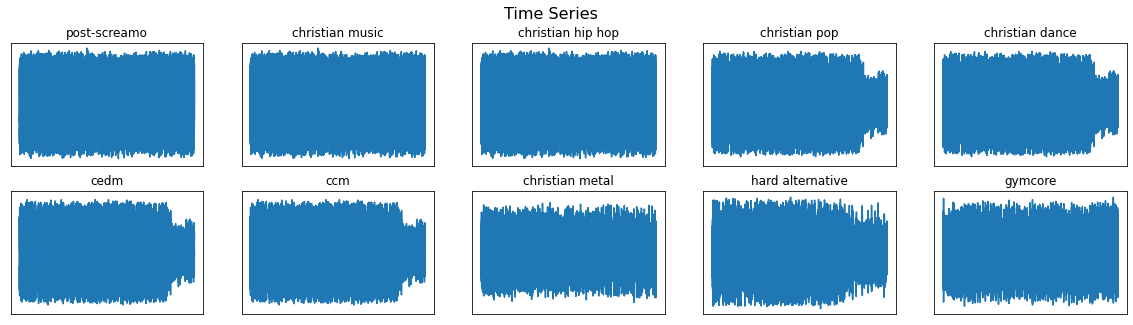

In [34]:
plot_signals(signals);

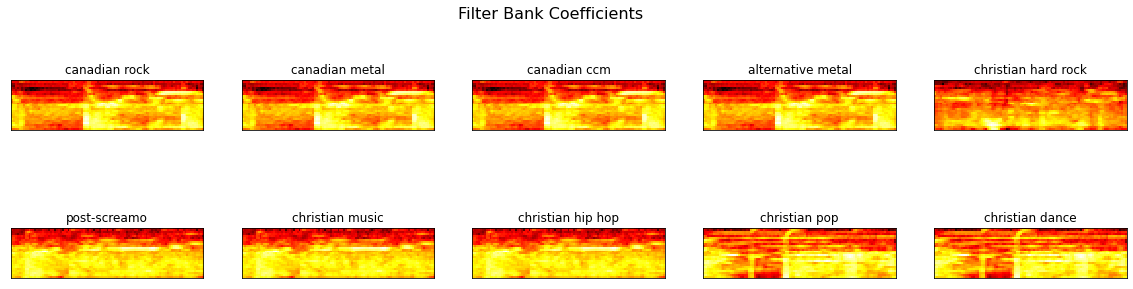

In [18]:
plot_fbank(fbank, signals);

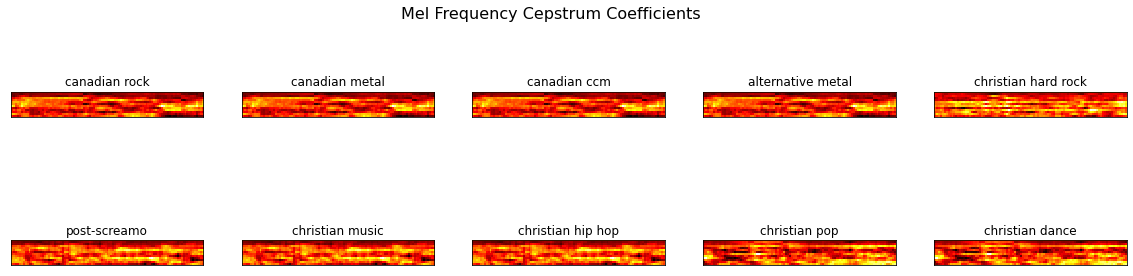

In [19]:
plot_mfccs(mfccs, signals);

### Insights

Right now, this is very basic EDA that I am borrowing from [Seth Adams's video](https://www.youtube.com/watch?v=Z7YM-HAz-IY&list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P), and many of these graphs are the same song. What I'll need to do next is scrape many different genre-based playlists until I can identify 5-10 genres that seem to be the most popular.

Even with this limited EDA, the Mel Frequency Cepstrum Coefficients for songs do look different, and if there are common traits between songs within genres, I will be able to classify them.

## Milestones
* Plan out directory structure for easy data collection and retrieval
* Decide on genres to classify
* Extract instrumentation/pitch/key/tempo
* Engineer features based on the data I can extract directly from the audio signal
* Test standard models, if I can (maybe looking at raw data?)
* Train Neural Network (looking at spectrogram)
* Classify 5 audibly disparate genres well
* Classify 5 audibly similar genres well